# ML3_Final Project: Vision Transformer with Metadata Integration for Skin Cancer Detection

LT7


## Step 1: Setup Environment

In [1]:
import torch

# Check if GPU is available
print(f"CUDA Device Count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU.")



CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


## Step 2: Install and Import Necessary Libraries

In [2]:
# !pip install transformers torch torchvision pandas scikit-learn imbalanced-learn seaborn
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from transformers import ViTModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt



## Step 3: Data Preparation

### Step 3.1: Load and Preprocess Metadata

In [3]:
# Load the metadata and drop unnecessary columns

metadata = pd.read_csv('train-metadata.csv')

columns_to_remove = [
    'lesion_id',
    'patient_id',
    'copyright_license',
    'iddx_full',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'mel_mitotic_index',
    'mel_thick_mm'
]

metadata.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Step 3.2: Fill Missing Values for Relevant Columns
metadata.fillna({
    'age_approx': metadata['age_approx'].median(),
    'sex': 'unknown',
    'anatom_site_general': 'unknown'
}, inplace=True)
metadata.info()

C:\Users\Harold David\AppData\Local\Temp\ipykernel_6244\728268865.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('train-metadata.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 44 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   age_approx                    401059 non-null  float64
 3   sex                           401059 non-null  object 
 4   anatom_site_general           401059 non-null  object 
 5   clin_size_long_diam_mm        401059 non-null  float64
 6   image_type                    401059 non-null  object 
 7   tbp_tile_type                 401059 non-null  object 
 8   tbp_lv_A                      401059 non-null  float64
 9   tbp_lv_Aext                   401059 non-null  float64
 10  tbp_lv_B                      401059 non-null  float64
 11  tbp_lv_Bext                   401059 non-null  float64
 12  tbp_lv_C                      401059 non-nul

Checking on missing values

In [4]:
metadata.isnull().sum()

isic_id                         0
target                          0
age_approx                      0
sex                             0
anatom_site_general             0
clin_size_long_diam_mm          0
image_type                      0
tbp_tile_type                   0
tbp_lv_A                        0
tbp_lv_Aext                     0
tbp_lv_B                        0
tbp_lv_Bext                     0
tbp_lv_C                        0
tbp_lv_Cext                     0
tbp_lv_H                        0
tbp_lv_Hext                     0
tbp_lv_L                        0
tbp_lv_Lext                     0
tbp_lv_areaMM2                  0
tbp_lv_area_perim_ratio         0
tbp_lv_color_std_mean           0
tbp_lv_deltaA                   0
tbp_lv_deltaB                   0
tbp_lv_deltaL                   0
tbp_lv_deltaLB                  0
tbp_lv_deltaLBnorm              0
tbp_lv_eccentricity             0
tbp_lv_location                 0
tbp_lv_location_simple          0
tbp_lv_minorAx

In [5]:
metadata

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,...,0.000000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,97.517282
1,ISIC_0015845,0,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,...,0.000000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,3.141455
2,ISIC_0015864,0,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,...,0.000000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,99.804040
3,ISIC_0015902,0,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,...,0.664690,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,99.989998
4,ISIC_0024200,0,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,...,0.000000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,14.944666,...,2.328066,7.054819,2.169398,0.288920,100,147.187256,1182.317505,122.652588,"Department of Dermatology, Hospital Clínic de ...",99.999988
401055,ISIC_9999951,0,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,16.026870,...,1.048147,1.879502,2.910780,0.460000,25,52.349740,1393.187000,127.261700,Memorial Sloan Kettering Cancer Center,99.999820
401056,ISIC_9999960,0,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,12.364397,...,0.607554,1.702824,2.205272,0.183099,40,54.622246,1065.263672,-106.833740,"Frazer Institute, The University of Queensland...",99.999416
401057,ISIC_9999964,0,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,9.564721,...,1.078204,3.680175,1.957157,0.161850,140,-9.861557,877.527000,-76.982120,University Hospital of Basel,100.000000


### Step 3.3: Scale and combine Numeric and Categorical Columns

In [6]:
numeric_cols = [col for col in metadata.select_dtypes(include=['float64', 'int64']).columns if col != 'target']
categorical_cols = [col for col in metadata.select_dtypes(include=['object']).columns if col not in ['isic_id', 'target']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply transformations
metadata_encoded_array = preprocessor.fit_transform(metadata)
#converts to dataframe
metadata_encoded = pd.DataFrame(
    metadata_encoded_array, columns=numeric_cols + list(
        preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    )
)
metadata_encoded['isic_id'] = metadata['isic_id'].values
metadata_encoded['target'] = metadata['target'].values

metadata_encoded

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_location_simple_Unknown,attribution_ACEMID MIA,"attribution_Department of Dermatology, Hospital Clínic de Barcelona","attribution_Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris","attribution_Frazer Institute, The University of Queensland, Dermatology Research Centre",attribution_Memorial Sloan Kettering Cancer Center,attribution_University Hospital of Basel,"attribution_ViDIR Group, Department of Dermatology, Medical University of Vienna",isic_id,target
0,0.145624,-0.511069,0.067613,0.380443,-0.257500,-0.659882,-0.192995,-0.407543,-0.288931,-0.917620,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0015670,0
1,0.145624,-1.624050,2.935019,2.959583,-0.369545,-0.527265,1.126869,0.906538,-2.708061,-3.006591,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0015845,0
2,0.145624,-0.304536,0.650540,0.625867,1.835454,1.466075,1.644677,1.385391,0.835409,0.339647,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0015864,0
3,0.514637,-0.407803,-1.433104,-0.780446,-1.294561,-1.291919,-1.583639,-1.355725,0.318926,-0.166282,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015902,0
4,-0.223390,-0.688917,1.188031,1.455843,-0.344179,-0.268249,0.250792,0.349419,-1.396095,-1.590171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0024200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,0.883650,1.646049,0.650166,0.007202,-0.117160,-0.032541,0.160952,-0.054822,-0.700893,-0.030617,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_9999937,0
401055,0.145624,-0.470910,0.000908,0.313829,1.113374,0.914313,0.838322,0.825604,0.910238,0.297111,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_9999951,0
401056,0.514637,-1.079034,-0.660445,-0.723881,0.296215,-0.092113,-0.047848,-0.347591,0.941991,0.708522,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,ISIC_9999960,0
401057,-2.068456,-0.648757,0.578715,-1.517130,0.028320,0.022136,0.234743,-0.469141,-0.497799,1.687649,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ISIC_9999964,0


### Step 3.5: Undersampling to Address Imbalance

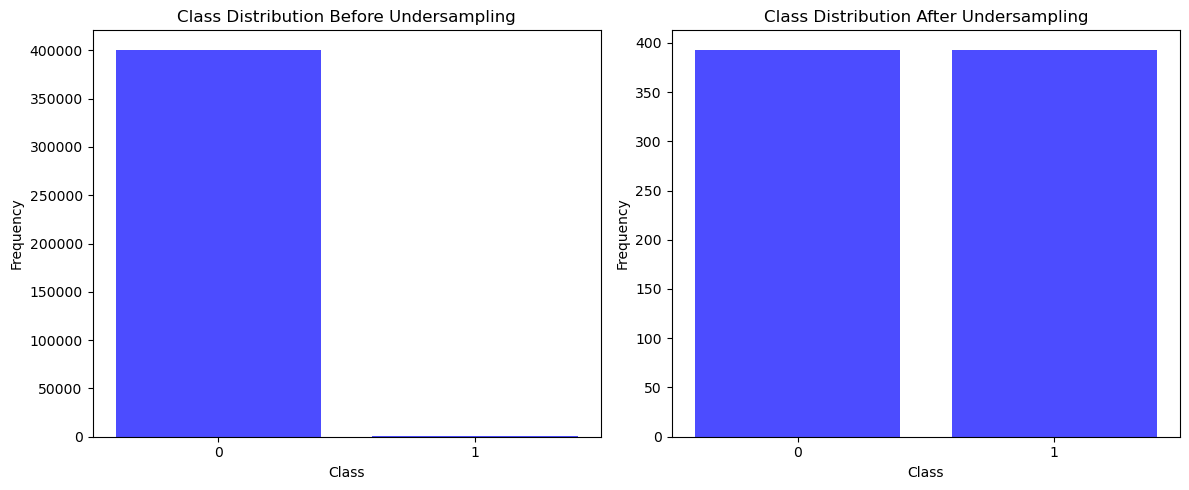

In [7]:
# Perform undersampling
isic_id_column = metadata_encoded['isic_id']
X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(metadata_encoded, metadata['target'])

# Separate the resampled isic_id from the resampled features
isic_id_resampled = X_resampled['isic_id']
X_resampled = X_resampled.drop(columns=['isic_id'])

# Get the correct column names for the encoded DataFrame
column_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Combine resampled data back into a DataFrame
metadata_resampled = pd.DataFrame(X_resampled, columns=column_names)
metadata_resampled['isic_id'] = isic_id_resampled
metadata_resampled['target'] = y_resampled


# Plot class distributions
plt.figure(figsize=(12, 5))

# Before undersampling
plt.subplot(1, 2, 1)
plt.bar([0, 1], metadata['target'].value_counts().sort_index(), color='blue', alpha=0.7)
plt.title('Class Distribution Before Undersampling')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1])

# After undersampling
plt.subplot(1, 2, 2)
plt.bar([0, 1], metadata_resampled['target'].value_counts().sort_index(), color='blue', alpha=0.7)
plt.title('Class Distribution After Undersampling')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1])

plt.tight_layout()
plt.show()

In [8]:
metadata_resampled

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_location_simple_Unknown,attribution_ACEMID MIA,"attribution_Department of Dermatology, Hospital Clínic de Barcelona","attribution_Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris","attribution_Frazer Institute, The University of Queensland, Dermatology Research Centre",attribution_Memorial Sloan Kettering Cancer Center,attribution_University Hospital of Basel,"attribution_ViDIR Group, Department of Dermatology, Medical University of Vienna",isic_id,target
366867,0.145624,-0.763498,0.258459,0.877515,0.366998,0.538874,0.353393,0.724559,0.097802,-0.454340,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_9153490,0
3463,-0.223390,-0.361907,-0.734645,-0.587000,0.886777,0.590421,0.406127,0.271222,1.451854,0.978726,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,ISIC_0157465,0
251028,0.514637,1.215773,0.466231,1.024232,0.884551,1.200511,0.831149,1.307450,0.328093,-0.150665,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_6306355,0
92251,1.990690,-0.809394,0.245252,-0.186074,1.159427,0.945692,0.962637,0.691803,0.724509,0.781882,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_2358370,0
60498,0.514637,-0.476647,1.671106,-1.780548,-1.583680,-1.398254,-0.264003,-1.769080,-3.238971,1.119533,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_1565789,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396165,-0.592403,2.426283,-0.655672,-1.011629,-0.828006,-0.504221,-0.918449,-0.783108,-0.112534,0.760694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,ISIC_9877311,1
398671,0.145624,0.986292,0.504308,-0.236834,1.131458,1.517853,1.036959,1.163573,0.479306,1.124572,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_9941636,1
399936,0.145624,2.627079,-0.242683,-0.875768,-1.238986,-0.767991,-1.035367,-0.960595,-1.052214,0.400611,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_9972649,1
399943,0.514637,4.675194,0.872918,0.986302,-2.069170,-1.409264,-0.980646,-0.684066,-3.289385,-2.268354,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_9972877,1


### Step 3.6: Update the Dataset Class


In [9]:
class SkinCancerDataset(Dataset):
    def __init__(self, metadata, image_dir, transform=None):
        self.metadata = metadata.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        
        # Assuming metadata_features is derived from metadata
        self.metadata_features = self.metadata.drop(columns=['isic_id', 'target']).values

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.metadata.iloc[idx]['isic_id'] + '.jpg') 
        image = Image.open(img_name).convert('RGB')
        label = self.metadata.iloc[idx]['target']
        metadata = torch.tensor(self.metadata_features[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, metadata, label


In [10]:
# Define transformations for images
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize dataset
image_dir = 'train-image/image'
dataset = SkinCancerDataset(metadata_encoded, image_dir, transform=transform)

seed = 42
torch.manual_seed(seed)

# Split dataset into training and validation sets
val_split = int(0.2 * len(dataset))
train_split = len(dataset) - val_split
train_dataset, val_dataset = random_split(
                                        dataset,
                                        [train_split, val_split],
                                        generator=torch.Generator().manual_seed(seed)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



## Step 4: Model Setup


In [11]:
# Define the model
class SimpleViTWithMetadata(nn.Module):
    def __init__(self, vit_model, metadata_input_size):
        super(SimpleViTWithMetadata, self).__init__()
        self.vit = vit_model
        self.metadata_fc = nn.Linear(metadata_input_size, 128)
        self.fc = nn.Linear(768 + 128, 2)
    
    def forward(self, images, metadata):
        vit_features = self.vit(images).last_hidden_state[:, 0, :]
        metadata_features = torch.relu(self.metadata_fc(metadata))
        combined_features = torch.cat((vit_features, metadata_features), dim=1)
        output = self.fc(combined_features)
        return output

# Instantiate the Vision Transformer model
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model = SimpleViTWithMetadata(vit_model, metadata_input_size=metadata_resampled.shape[1] - 2)  # Adjust based on your metadata


In [12]:
metadata_resampled.shape

(786, 85)

## Step 5: Training and Validation Functions

In [13]:
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, metadata, target) in enumerate(train_loader):
        data, metadata, target = data.to(device), metadata.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data, metadata)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, metadata, target in val_loader:
            data, metadata, target = data.to(device), metadata.to(device), target.to(device)
            outputs = model(data, metadata)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)

    return running_loss / len(val_loader), accuracy, precision, recall


## Step 6: Training Loop

In [ ]:
from sklearn.metrics import precision_score, recall_score

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_precision, val_recall = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%, Precision: {val_precision}, Recall: {val_recall}')



C:\Users\Harold David\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


## Step 7: Validation Metrics and Visualization

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, metadata, target in val_loader:
            data, metadata, target = data.to(device), metadata.to(device), target.to(device)
            
            outputs = model(data, metadata)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)
    cr = classification_report(all_targets, all_predictions)

    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n", cr)

# Example usage after each epoch or after training
evaluate_model(model, val_loader)

# Plotting accuracy, precision, and recall over epochs
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_precisions, 'g', label='Validation Precision')
plt.title('Validation Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_recalls, 'r', label='Validation Recall')
plt.title('Validation Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()





Other steps:

Structure:
1. Metadata only
2. image only
3. Combination

Models:
1. VIT Pre-trained models
2. Classic ML
3. CNN Pre-trained models
4. 
